In [37]:
from scenario_run import ScenarioRunner
import pandas as pd
import os
import matplotlib.pyplot as plt
from utils.utils import Utils
import numpy as np

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
u = Utils()

In [40]:
# Set up paths
DIR_PATH = os.getcwd()
CONFIG_DIR_PATH = os.path.join(DIR_PATH, "config")
OUTPUT_DIR_PATH = os.path.join(DIR_PATH, "output")
FIGURES_DIR_PATH = os.path.join(OUTPUT_DIR_PATH, "figures")
SCENARIO_SIM_RESULTS_DIR_PATH = os.path.join(OUTPUT_DIR_PATH, "scenario_results")

In [41]:
# Get the yaml files with 'mty' in the file name from the config directory
yaml_files = [f for f in os.listdir(CONFIG_DIR_PATH) if f.endswith('.yaml') and 'mty' in f]
if not yaml_files:
    raise FileNotFoundError("No YAML file with 'mty' in the name found in the config directory.")

# remove .yaml extension from the file name
yaml_files = [f.replace('.yaml', '') for f in yaml_files]
yaml_files


['well_financed_mty',
 'proximate_mty',
 'reconceived_mty',
 'baseline_mty',
 'efficient_mty']

In [42]:
# Load yaml scenario yaml files
model_policies_dict = {}
for file in yaml_files:
    file_path = os.path.join(CONFIG_DIR_PATH, f"{file}.yaml")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Scenario file {file} does not exist.")
    model_policies_dict[file] = u.load_yaml(file_path)["model_policies"]


model_policies_dict

{'well_financed_mty': {'financial_availability': 0.95,
  'tax_rate': 0.004,
  'fraction_of_funding_for_transportation': 0.2,
  'zoning_and_regulation': 0.4,
  'fraction_of_investment_in_public_transportation': 0.35,
  'engagement_with_stakeholders': 0.85},
 'proximate_mty': {'financial_availability': 0.7,
  'tax_rate': 0.002,
  'fraction_of_funding_for_transportation': 0.3,
  'zoning_and_regulation': 0.5,
  'fraction_of_investment_in_public_transportation': 0.7,
  'engagement_with_stakeholders': 0.65},
 'reconceived_mty': {'financial_availability': 0.75,
  'tax_rate': 0.004,
  'fraction_of_funding_for_transportation': 0.18,
  'zoning_and_regulation': 0.5,
  'fraction_of_investment_in_public_transportation': 0.7,
  'engagement_with_stakeholders': 0.95},
 'baseline_mty': {'financial_availability': 0.7,
  'tax_rate': 0.002,
  'fraction_of_funding_for_transportation': 0.14,
  'zoning_and_regulation': 0.4,
  'fraction_of_investment_in_public_transportation': 0.2,
  'engagement_with_stakehol

In [43]:
# Run the scenario simulations
for yaml_file in yaml_files:
    print(f"Running scenario simulation for {yaml_file}...")
    scenario_runner = ScenarioRunner(yaml_file)
    scenario_runner.run()

Running scenario simulation for well_financed_mty...
Running scenario simulation for proximate_mty...
Running scenario simulation for reconceived_mty...
Running scenario simulation for baseline_mty...
Running scenario simulation for efficient_mty...


In [44]:
relevant_ouput_fields = [
    "city_sprawl",
    "time_in_traffic",
    "access_to_services",
    "rent_cost",
    "proximity_index",
    "houses"
]

In [45]:
# Go to scenario results directory and read the CSV files, store them in a dict of dataframes
os.chdir(SCENARIO_SIM_RESULTS_DIR_PATH)
csv_files = [f for f in os.listdir() if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV files found in the scenario results directory.")
scenario_data = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    # Remove 'scenario_sim_results_' prefix and '.csv' extension for the key
    scenario_name = csv_file.replace('scenario_sim_results_', '').replace('.csv', '')
    scenario_data[scenario_name] = df

scenario_data.keys()

dict_keys(['reconceived_mty', 'proximate_mty', 'baseline_mty', 'efficient_mty', 'well_financed_mty'])

In [46]:
import math

def plot_time_series_subplots(df, fields, title=None, figsize=(12, 2.5)):
    """
    Plots time series subplots for the given fields from the dataframe in two columns.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        fields (list): List of column names to plot.
        title (str, optional): Title for the figure.
        figsize (tuple, optional): Size of each subplot (width, height).
    """
    n = len(fields)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows), sharex=True)
    axes = axes.flatten()
    for i, field in enumerate(fields):
        axes[i].plot(df['time'], df[field])
        axes[i].set_ylabel(field)
        axes[i].grid(True, linestyle='--', alpha=0.5)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    axes[-1].set_xlabel('time')
    if title:
        fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97] if title else None)
    plt.show()

In [51]:
import math

def plot_time_series_subplots_compare(scenario_dfs, fields, title=None, figsize=(10, 2.5)):
    """
    Plots time series subplots for the given fields, comparing multiple dataframes in two columns.
    Legends are placed below all subplots.

    Parameters:
        scenario_dfs (dict): Dict of {label: pd.DataFrame} to compare.
        fields (list): List of column names to plot.
        title (str, optional): Title for the figure.
        figsize (tuple, optional): Size of each subplot (width, height).
    """
    n = len(fields)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows), sharex=True)
    axes = axes.flatten()
    lines = []
    labels = []
    for i, field in enumerate(fields):
        for label, df in scenario_dfs.items():
            line, = axes[i].plot(df['time'], df[field], label=label)
            if i == 0:
                lines.append(line)
                labels.append(label)
        axes[i].set_ylabel(field)
        axes[i].grid(True, linestyle='--', alpha=0.5)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    axes[-1].set_xlabel('time')
    if title:
        fig.suptitle(title)
    # Place legend below all subplots
    fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=len(scenario_dfs))
    plt.tight_layout(rect=[0, 0.05, 1, 0.97] if title else [0, 0.05, 1, 1])
    plt.show()
    plt.close(fig)


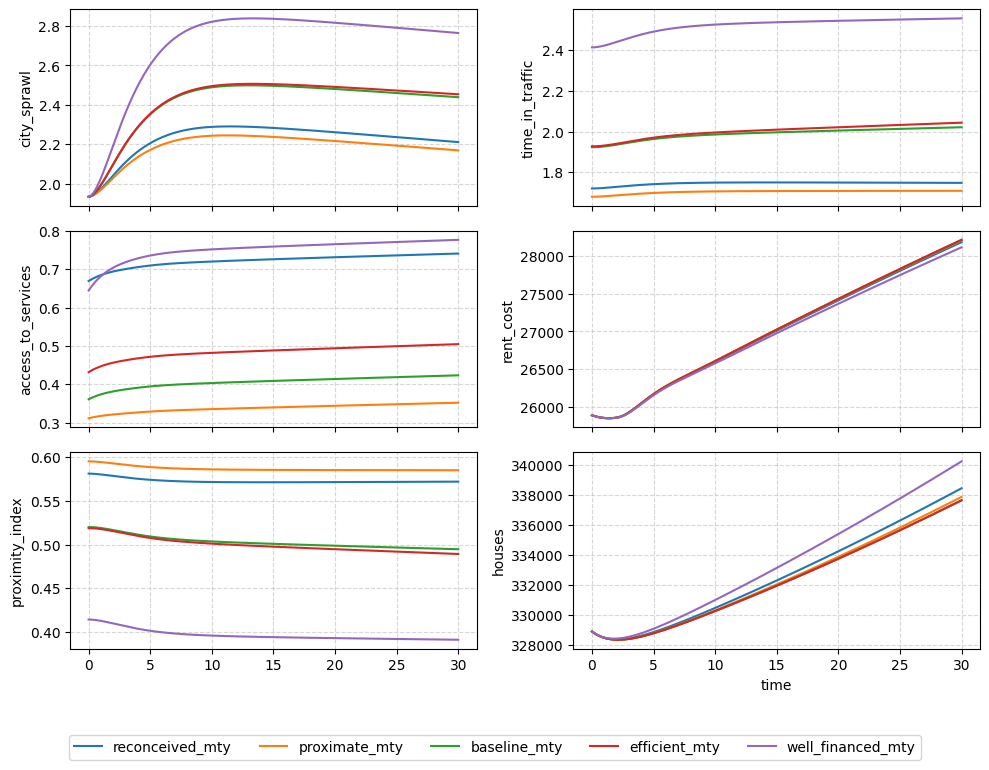

In [52]:
plot_time_series_subplots_compare(scenario_data, relevant_ouput_fields)

In [53]:
def plot_policy_scenarios(policy_dict):
    # Extract policy names and parameters
    scenarios = list(policy_dict.keys())
    parameters = list(next(iter(policy_dict.values())).keys())

    # Create an array of values for each parameter
    data = {param: [policy_dict[scenario][param] for scenario in scenarios] for param in parameters}

    # Bar width and x locations
    x = np.arange(len(scenarios))
    width = 0.12

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for i, (param, values) in enumerate(data.items()):
        positions = x + i * width
        bars = ax.bar(positions, values, width, label=param)

        # Add value labels
        for pos, val in zip(positions, values):
            ax.text(pos, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x + width * (len(parameters) - 1) / 2)
    ax.set_xticklabels(scenarios, rotation=45)
    ax.set_ylabel('Value')
    ax.set_title('Policy Parameter Values by Scenario')
    ax.legend(title='Policy Parameter', loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=3)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


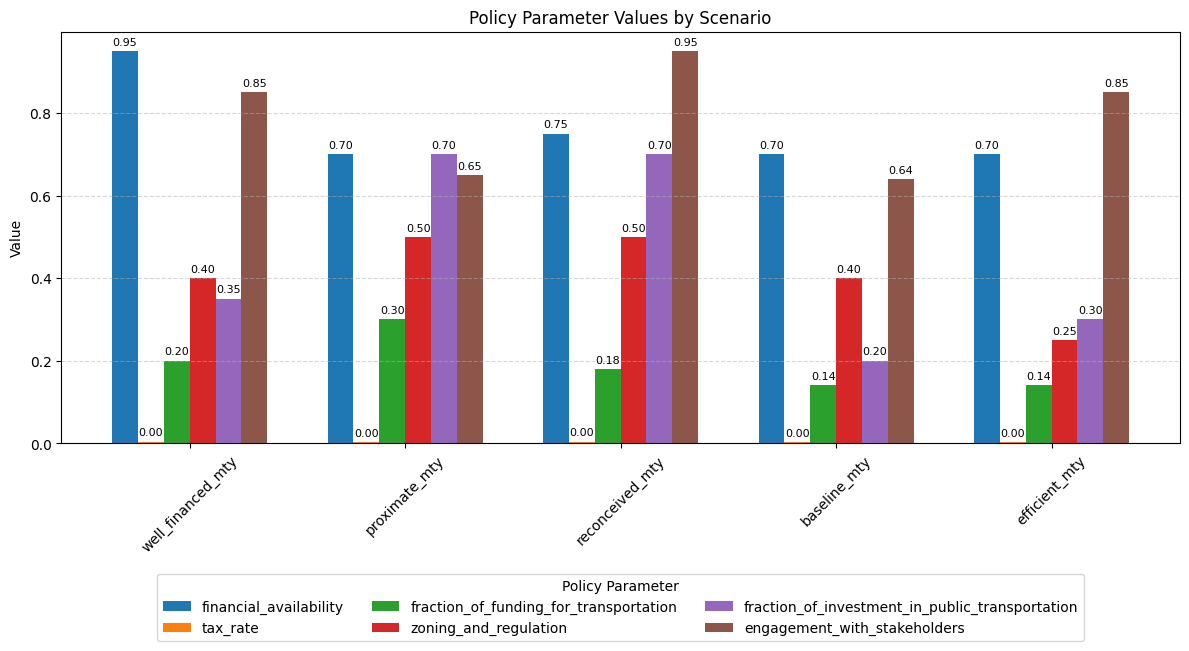

In [54]:
plot_policy_scenarios(model_policies_dict)